## Linear morph on test data

### Setup

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import scalar 
from kpsn.models.pose import gmm
from kpsn.models import joint_model
from kpsn.fitting import em
from kpsn import models
from kpsn import util

from mph.generative.test.visualize import mixtures
from mph.generative.test.visualize import morphs as viz_morphs

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import numpy as np
import optax
import jax
from tensorflow_probability.substrates import jax as tfp
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
from matplotlib import gridspec

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Sample dataset

In [6]:
T = 300; N = 3; M = 2; L = 5; eps = 0.05; modeL = 1
morph_hyperparams = afm.AffineModeMorphHyperparams(N = N, M = M, L = modeL, modes=None)
pose_hyperparams = gmm.GMMHyperparams(N = N, M = M, L = L, eps = eps)
model = joint_model.JointModel(morph = afm.AffineModeMorph, posespace = gmm.GMMPoseSpaceModel)
hyperparams = joint_model.JointHyperparams(morph = morph_hyperparams, posespace = pose_hyperparams)

gt_morph, gt_pose, gt_latents, gt_obs = joint_model.sample(
    jr.PRNGKey(0), T,
    model,
    hyperparams,
    dict(
        uniform_scale_std = 0.0,
        modal_scale_std = 0.3,
        mode_std = 0.3,
        update_std = 0.3
    ),
    dict(
        pi_logit_means = jnp.stack([2 * jnp.exp(jnp.linspace(-i_subj / 10, i_subj / 10, L))
                                    for i_subj in range(pose_hyperparams.N)]),
        pi_logit_vars = 0.06 * jnp.ones([N, L]),
        m_norm_center = 2,
        m_norm_spread = 0.4,
        q_var_center = 0.5,
        q_var_spread = 0.1),
)

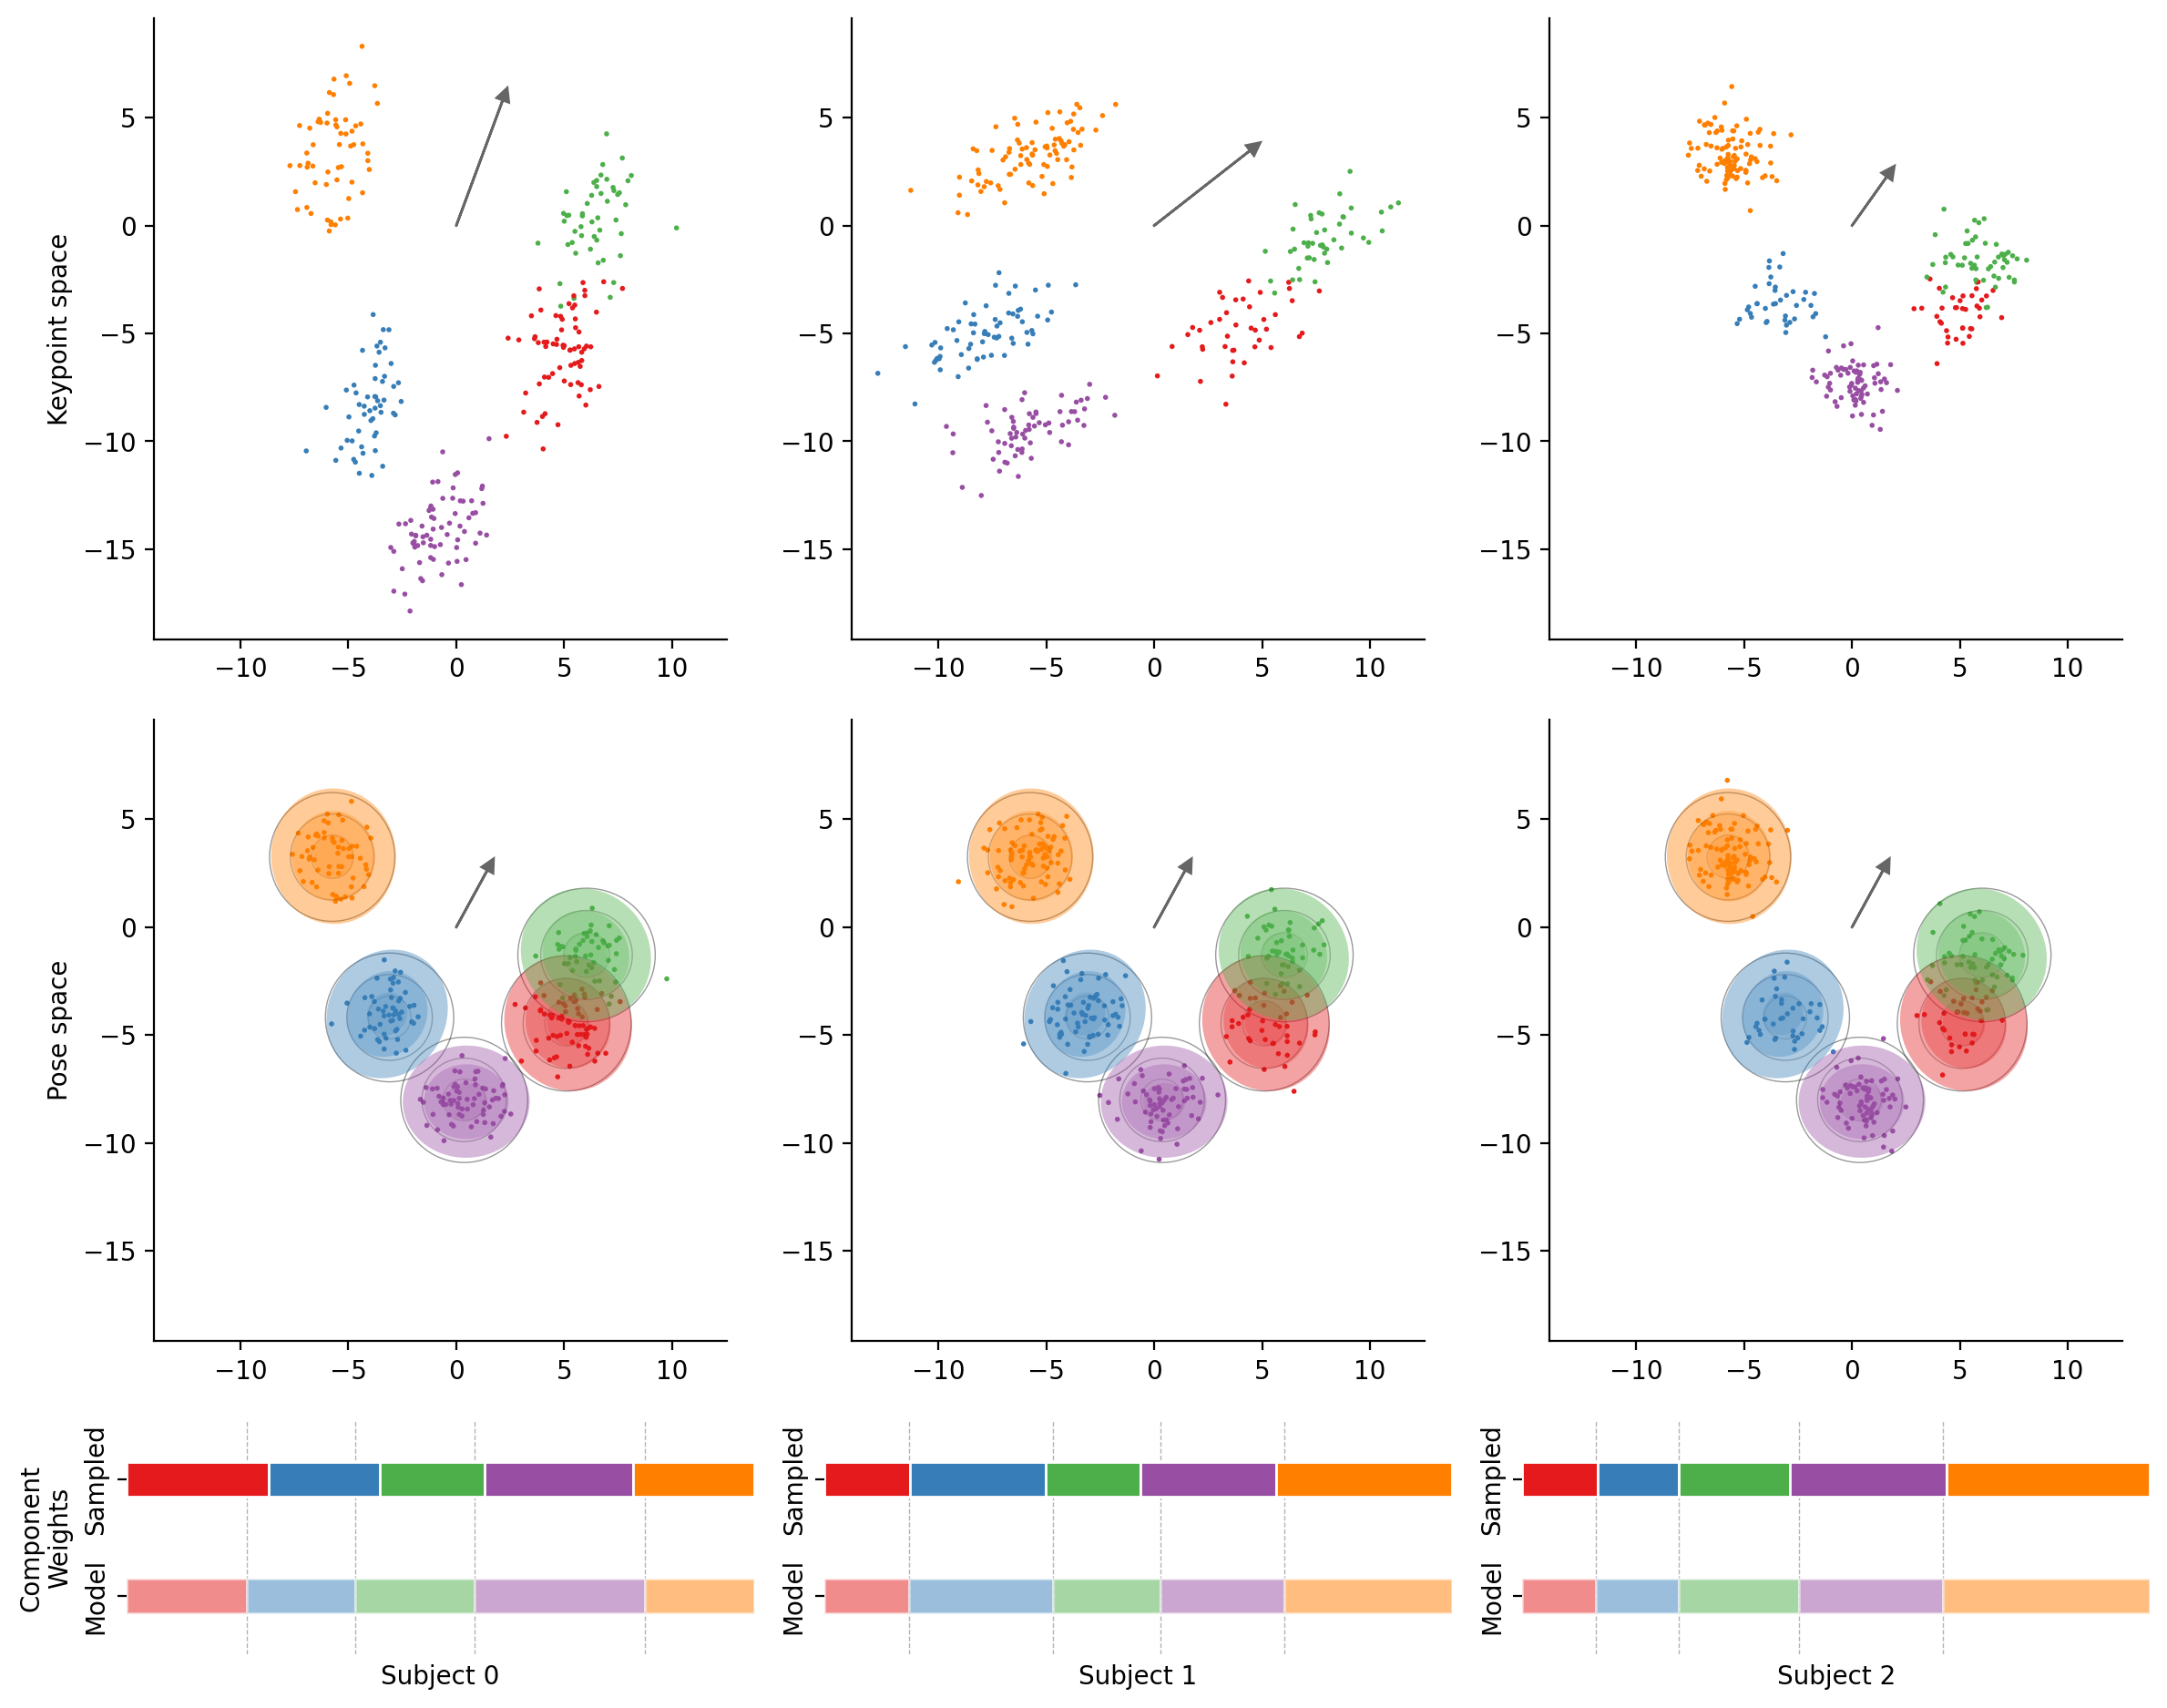

In [9]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, gt_pose, gt_latents, gt_obs)
viz_morphs.plot_morph_dimensions(ax[:2], morph_hyperparams, afm.AffineModeMorph, gt_morph, scale = 3)

### Single M-Step

In [10]:

loss_hist, fit_params = em.mstep(
    model = model,
    # init_params = smgmm_test.pertub_parameters(jr.PRNGKey(1), smgmm_data.params, 0.0),
    # estimated_params = smgmm_test.pertub_parameters(jr.PRNGKey(0), smgmm_data.params, 0.0),
    init_params = joint_model.JointParameters(posespace = gt_pose, morph = gt_morph),
    estimated_params = joint_model.JointParameters(posespace = gt_pose, morph = gt_morph),
    emissions = gt_obs,
    hyperparams = hyperparams,
    optimizer = optax.adam(learning_rate=5e-4),
    n_steps = 2000,
    log_every = -1,
    progress = False
)



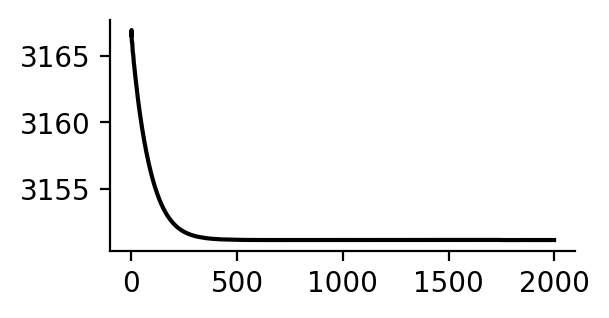

In [11]:
plt.figure(figsize = (3, 1.5))
plt.plot(loss_hist, 'k-')
sns.despine()

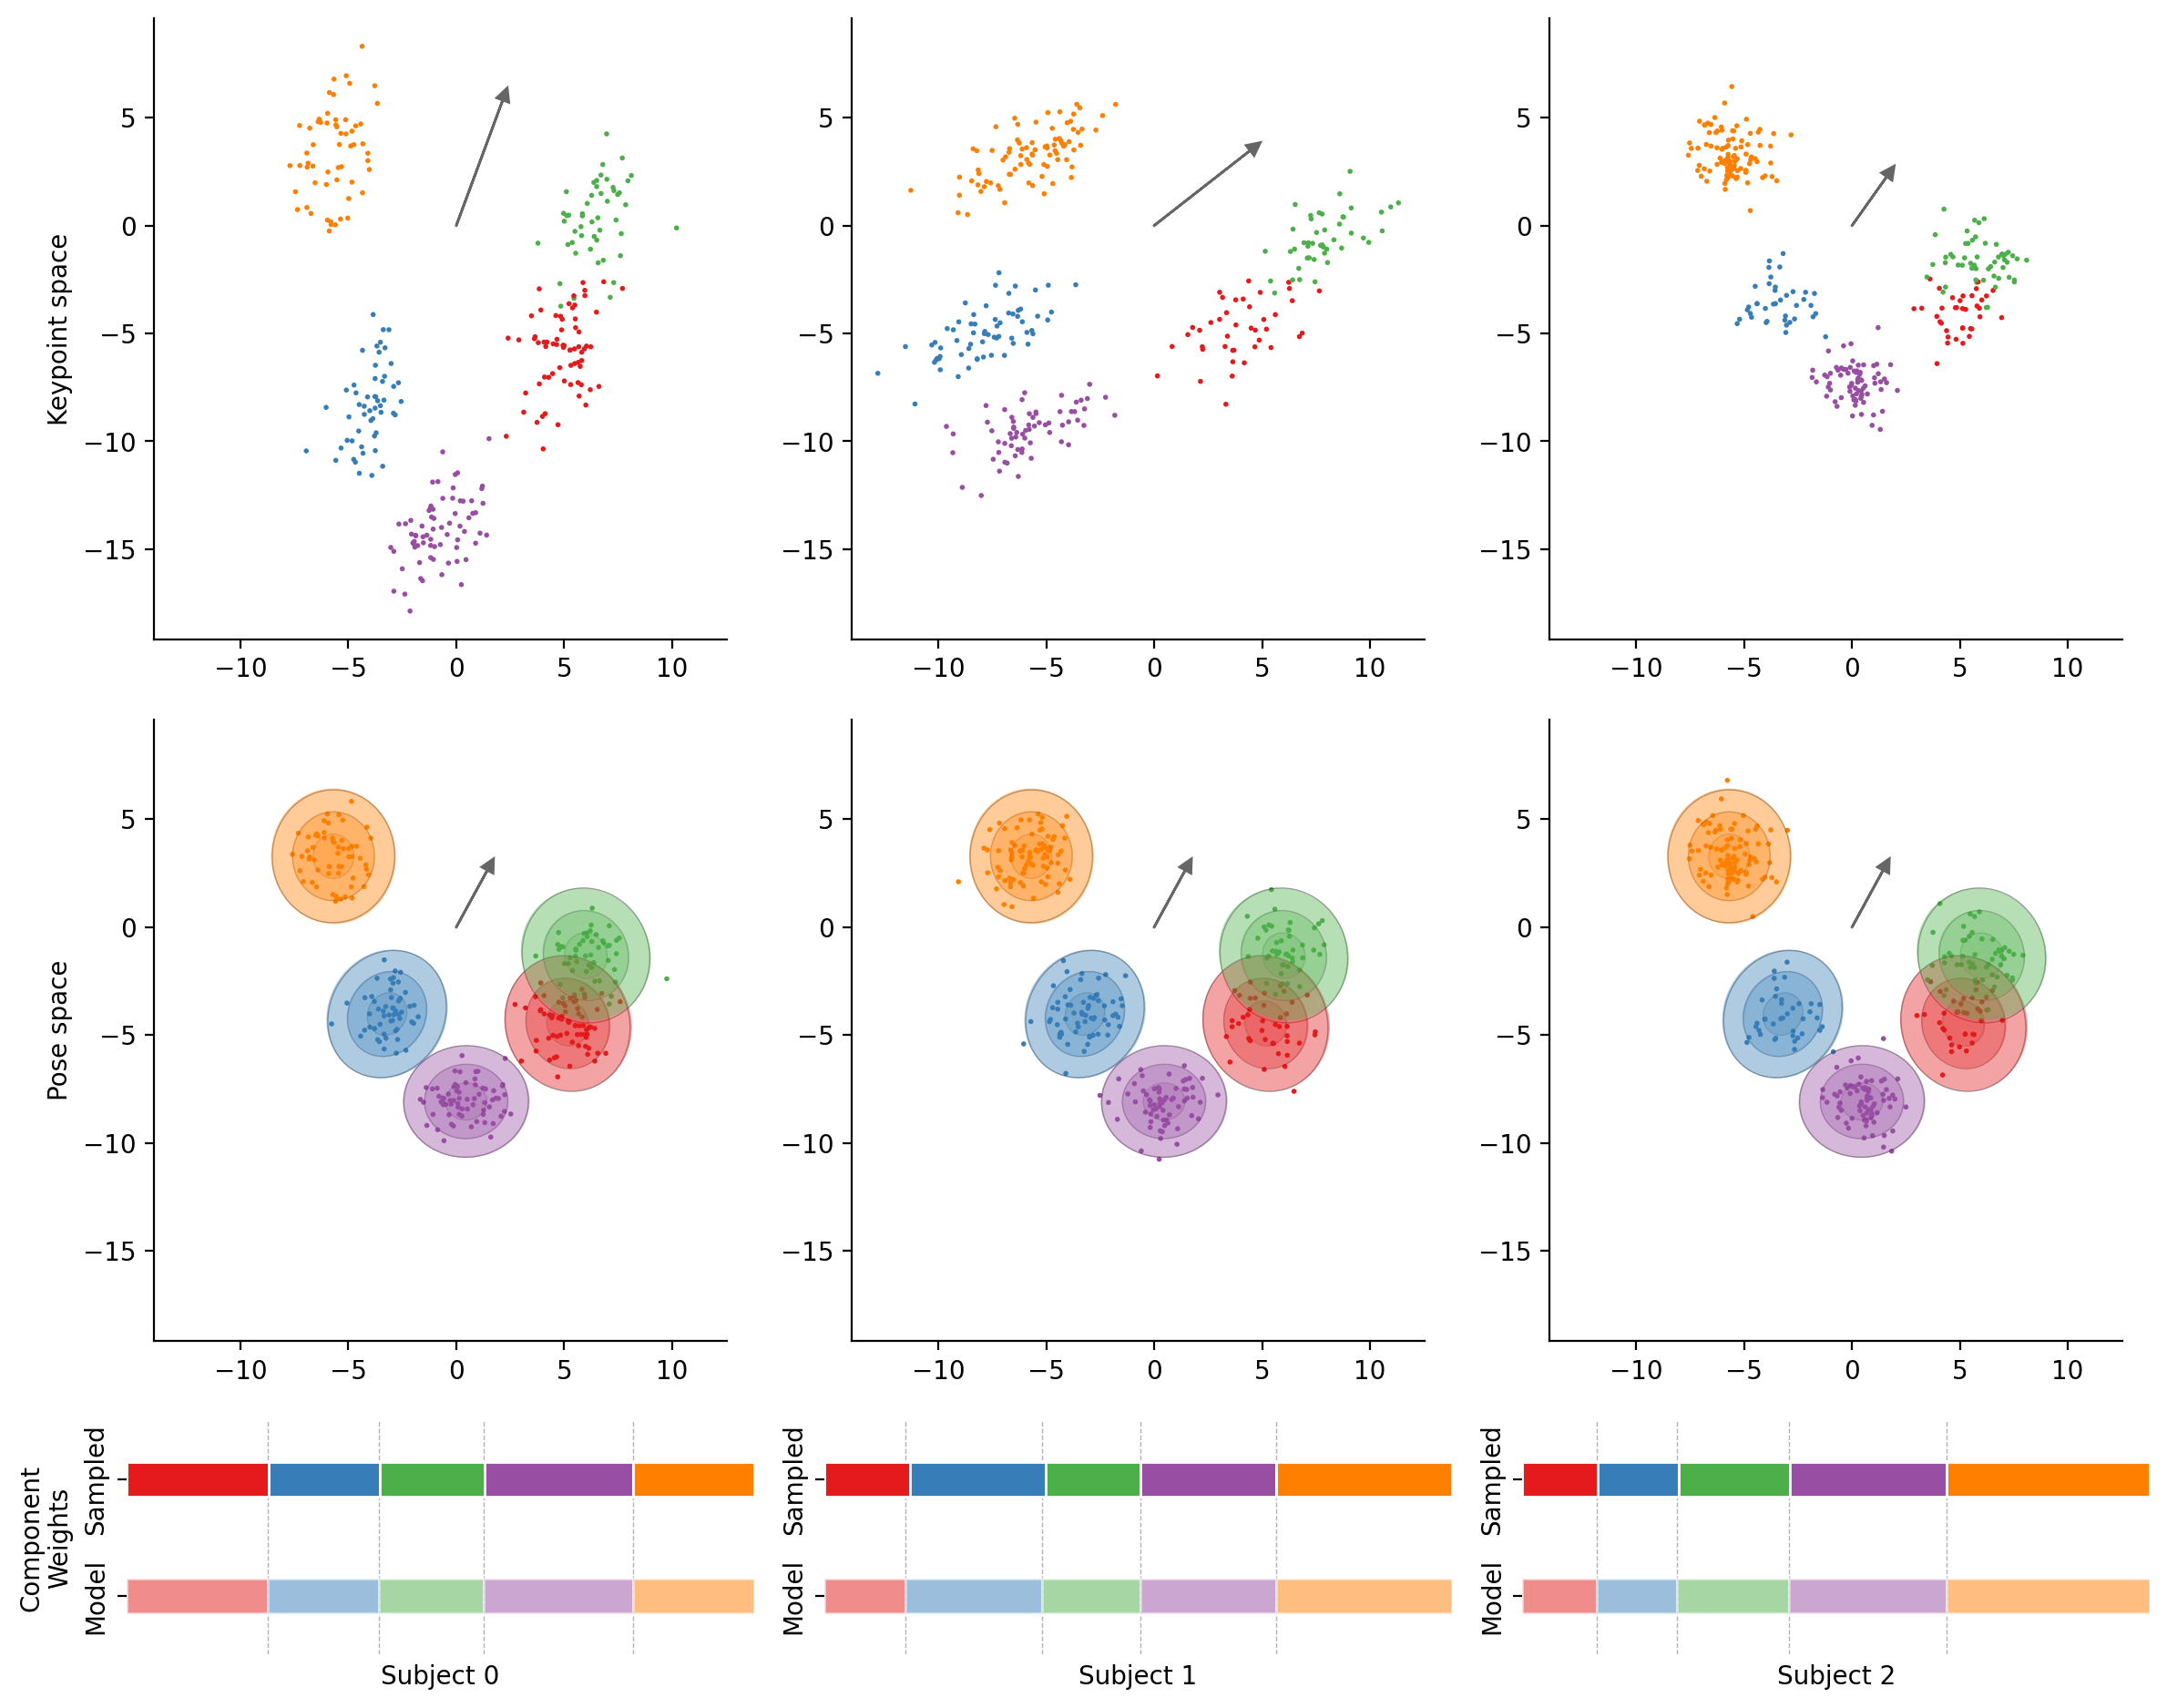

In [12]:
fig = plt.figure(figsize = (4 * pose_hyperparams.N, 8 + 1.5 + 1.5))
ax = mixtures.sampled_mixture_plot(fig, pose_hyperparams, fit_params.posespace, gt_latents, gt_obs)
viz_morphs.plot_morph_dimensions(ax[:2], morph_hyperparams, afm.AffineModeMorph, fit_params.morph, scale = 3)